In [104]:
import numpy as np
import itertools
import heapq

class QuoridorState:
    '''
    Quoridor state container class - generalized by size N
    Attributes:
        positions: 2x2 tuple representing the positions of the players
        left_wall: 1x2 tuple representing the number of walls left for each player
        walls: NxNx2 numpy array representing the walls
    '''
    def __init__(self, N: int = 9, n_walls: int = 10, copy: 'QuoridorState' = None):
        self.N = N
        if copy is not None:
            self.N = copy.N
            self.positions = copy.positions.copy()
            self.left_wall = copy.left_wall.copy()
            self.walls = copy.walls.copy()
            self.board = copy.board.copy()
        else:
            self.positions = np.array([[0, self.N // 2], [self.N - 1, self.N // 2]])
            self.left_wall = np.array([n_walls, n_walls])
            self.walls = np.zeros((2, self.N - 1, self.N - 1), dtype=np.int8)
            self.board = self.init_board()


    def init_board(self):
        '''
        Returns a 2N-1x2N-1 numpy array representing the board
        '''
        board = np.zeros((self.N * 2 - 1, self.N * 2 - 1), dtype=np.int8)
        board[1::2, 1::2] = 1
        board[self.positions[0, 0] * 2, self.positions[0, 1] * 2] = 2
        board[self.positions[1, 0] * 2, self.positions[1, 1] * 2] = 3
        return board

    def copy(self):
        return QuoridorState(copy=self)
    
    def encode(self, player):
        '''
        Returns 4xNxN numpy array representing the state
        channel 1: position of player 0
        channel 2: position of player 1
        channel 3: horizontal walls
        channel 4: vertical walls
        '''
        encoded = np.zeros((4, self.N, self.N), dtype=np.float32)
        encoded[player, self.positions[0, 0], self.positions[0, 1]] = 1
        encoded[1 - player, self.positions[1, 0], self.positions[1, 1]] = 1
        encoded[2, :, :] = np.pad(self.walls[0, :, :] == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        encoded[3, :, :] = np.pad(self.walls[1, :, :] == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        return encoded

class Quoridor:
    '''
    Quoridor rule management class
    '''
    def __init__(self, N, n_walls):
        self.N = N
        self.n_walls = n_walls
    
    def get_initial_state(self):
        '''
        Returns the initial state of the game
        '''
        state = QuoridorState(self.N, self.n_walls)
        return state
    
    def _search_on_board(self, state: QuoridorState, player):
        '''
        Returns the distance of shortest path to the goal of given player using a* algorithm.
        1 is wall, 0 is path
        if player 0: end at (2N - 2, *)
        if player 1: end at (0, *)
        heuristic: column-distance to the goal
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        queue = []
        heuristic = lambda pos: (2 * self.N - 2 - pos[0]) * (1 - player) + (2 * pos[0]) * player
        heapq.heappush(queue, (-heuristic(now_pos), 0, -1, now_pos))
        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        for cnt in itertools.count():
            if len(queue) == 0:
                return -1
            _, g, _, pos = queue.pop()
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if pos[0] == (2 * self.N - 2) * (1 - player):
                return g
            visited[*pos] = 1
            for i in range(4):
                e = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])[i]
                heapq.heappush(queue, (-(heuristic(pos + e) + g + 1), g + 1, 4 * cnt + i, pos + e))


    def is_valid_wall(self, state: QuoridorState):
        '''
        Returns True if the state is valid, False otherwise
        Conditions for a valid state:
            - Walls are not blocking the path to the goal
        '''
        for i in range(2):
            if self._search_on_board(state, i) == -1:
                return False
        return True
    
    def _search_valid_moves(self, state: QuoridorState, player):
        '''
        Returns a list of valid moves from the given position using dfs
        1 is wall, 0 is path
        2 is player 0, 3 is player 1
        stack: [(pos, n_step)]
        n_step stops at 2
        reset step when board[pos] == 2 or 3
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        movable = []
        stack = []
        stack.append((now_pos, 0))
        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        while len(stack) > 0:
            pos, step = stack.pop()
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if board[*pos] == 2 or board[*pos] == 3:
                step = 0
            visited[*pos] = 1
            if step == 2:
                movable.append(pos // 2)
                continue
            for e in np.array([[-1, 0], [1, 0], [0, -1], [0, 1]]):
                stack.append((pos + e, step + 1))

        return movable


    def is_valid_move(self, state: QuoridorState, next_pos, player):
        '''
        Returns True if the next state is a valid move, False otherwise
        Conditions for a valid move:
            - The player is moving to a valid position
        '''
        cvt_pos = np.array(next_pos)
        if any([np.array_equal(cvt_pos, val_mov) for val_mov in self._search_valid_moves(state, player)]):
            return True
        else:
            return False


    def get_next_state(self, state: QuoridorState, action: tuple, player: int):
        '''
        Returns the next state of the game given the current state and action
        '''
        action_type, action_value = action
        next_state = QuoridorState(copy=state)
        if action_type == 0:
            if self.is_valid_move(next_state, action_value, player):
                next_state.board[*next_state.positions[player] * 2] = 0
                next_state.board[*np.array(action_value) * 2] = player + 2
                next_state.positions[player] = action_value
                return next_state
            else:
                # print('Invalid move')
                return None
        else:
            if next_state.left_wall[player] == 0:
                # print('No wall left')
                return None
            
            hv = action_type - 1
            row, col = action_value
            if next_state.walls[hv, row, col] != 0:
                # print('Invalid wall')
                return None
            
            next_state.walls[hv, row, col] = 1
            next_state.walls[1 - hv, row, col] = -1
            if hv == 0 and col > 0:
                next_state.walls[0, row, col - 1] = -1
            if hv == 1 and row > 0:
                next_state.walls[1, row - 1, col] = -1
            if hv == 0 and col < self.N - 2:
                next_state.walls[0, row, col + 1] = -1
            if hv == 1 and row < self.N - 2:
                next_state.walls[1, row + 1, col] = -1
            next_state.board[
                row * 2 - hv + 1 : row * 2 + hv + 2,
                col * 2 - (1 - hv) + 1 : col * 2 + (1 - hv) + 2
            ] = 1
            next_state.left_wall[player] -= 1
            if not self.is_valid_wall(next_state):
                # print('Invalid wall')
                return None

            return next_state

    def get_valid_actions(self, state: QuoridorState, player: int):
        moves = self._search_valid_moves(state, player)
        walls = [
            (a, (b, c))
            for a in range(2) for b in range(self.N - 1) for c in range(self.N - 1) 
            if self.get_next_state(state, (1, (a, b, c)), player) is not None
        ]
        return [(0, tuple(move)) for move in moves] + [(1 + a, p) for a, p in walls]

    def check_win(self, state: QuoridorState, player):
        '''
        Returns True if the player wins, False otherwise
        '''
        if state.positions[player][0] == (self.N - 1) * (1 - player):
            return True
        else:
            return False
    
    def get_draw_value(self, state: QuoridorState, player: int):
        '''
        Returns the reward of the given state. Possibly value can be heuristic, not only win-lose.
        '''
        p_value = self._search_on_board(state, player)
        o_value = self._search_on_board(state, 1 - player)
        return p_value / (p_value + o_value)
        
    def get_value_and_terminated(self, state: QuoridorState, player: int, turn_count: int):
        '''
        Returns whether the game is terminated and the reward of the given state.
        If the game progresses more than 50 turns, the game is forced to terminate.
        '''
        if turn_count > 50:
            return True, True, self.get_draw_value(state, player)
        if self.check_win(state, player):
            return True, False, 1
        else:
            return False, False, 0
        

def parse_cmd(cmd: str) -> tuple:
    s = cmd.split(' ')
    if s[0] == 'move':
        return 0, (int(s[1]), int(s[2]))
    elif s[0] == 'wall':
        return 1 + s[1], (int(s[2]), int(s[3]))
    else:
        raise ValueError('Invalid action type')


In [103]:
quoridor = Quoridor(5, 1)
state = quoridor.get_initial_state()
state = quoridor.get_next_state(state, (1, (0, 0)), 1)
state = quoridor.get_next_state(state, (2, (3, 3)), 0)

print(state.board)
print(state.encode(0))

[[0 0 0 0 2 0 0 0 0]
 [1 1 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0]
 [0 0 0 0 3 0 0 1 0]]
[[[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]]]


In [107]:
import math
import random

import tqdm


class Node:
    def __init__(
            self,
            game: Quoridor,
            args,
            state: QuoridorState,
            player,
            turn_count: int,
            parent: 'Node' = None,
            action_taken = None):
        
        self.game = game
        self.args = args
        self.state = state
        self.player = player
        self.turn_count = turn_count
        self.parent = parent
        self.action_taken = action_taken

        self.children: list['Node'] = []
        self.expandable_actions = self.game.get_valid_actions(self.state, self.player)

        self.visit_count = 0
        self.total_value = 0

    def is_fully_expanded(self):
        return len(self.expandable_actions) == 0 and len(self.children) > 0
    
    def select(self) -> 'Node':
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child

        return best_child

    def get_ucb(self, child: 'Node'):
        q_value = child.total_value / child.visit_count + 1e-5
        return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count) / child.visit_count)
    

    def expand(self):
        action = random.choice(self.expandable_actions)
        self.expandable_actions.remove(action)

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, self.player)

        child = Node(self.game, self.args, child_state, 1 - self.player, self.turn_count + 1, self, action)
        self.children.append(child)
        return child
    
    def simulate(self):
        rollout_state = self.state.copy()
        rollout_player = self.player
        rollout_count = self.turn_count
        while True:
            # print(self.turn_count, rollout_count)
            is_terminal, is_draw, value = self.game.get_value_and_terminated(rollout_state, rollout_player, rollout_count)
            if is_terminal:
                return is_draw, value
            rollout_player = 1 - rollout_player

            valid_moves = self.game.get_valid_actions(rollout_state, rollout_player)
            action = random.choice(valid_moves)
            rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
            rollout_count += 1

    def backpropagate(self, value, is_draw):
        self.visit_count += 1
        if is_draw:
            self.total_value += value * self.args['draw_discount']
        else:
            self.total_value += value

        if self.parent is not None:
            self.parent.backpropagate(value, is_draw)


class MCTS:
    def __init__(self, game: Quoridor, args) -> None:
        self.game = game
        self.args = args

    def search(self, state, player):
        root = Node(self.game, self.args, state, player, 0)

        for search in tqdm.tqdm(range(self.args['N'])):
            # print(search)
            node = root

            while node.is_fully_expanded():
                # print(node.expandable_actions, node.children)
                node = node.select()

            is_terminal, is_draw, value = self.game.get_value_and_terminated(node.state, 1 - node.player, node.turn_count)

            if not is_terminal:
                node = node.expand()
                is_draw, value = node.simulate()
            node.backpropagate(value, is_draw)
        
        action_probs = np.zeros(len(root.children))
        actions = [child.action_taken for child in root.children]
        data = [(child.visit_count, child.total_value) for child in root.children]
        for idx, child in enumerate(root.children):
            action_probs[idx] = child.total_value / child.visit_count
        print('Search nodes:', data)
        action_probs /= np.sum(action_probs)
        return actions, action_probs



In [91]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv2 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = F.relu(x)
        return x

class QuoridorNet(nn.Module):
    def __init__(self, game: Quoridor, num_resBlocks, n_channels):
        super().__init__()
        self.start_block = nn.Sequential(
            nn.Conv2d(4, n_channels, 3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU()
        )
        self.backbone = nn.Sequential(
            OrderedDict(
                [('backbone_resblock_{}'.format(i), ResBlock(n_channels)) for i in range(num_resBlocks)]
            
            )
        )

        self.policy_head = nn.Sequential(
            nn.Conv2d(n_channels, n_channels, 1, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, 3, 3, padding=1),
            nn.Sigmoid(),
        )

        self.value_head = nn.Sequential(
            nn.Conv2d(n_channels, 3, 1, padding=0),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.N * game.N, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.start_block(x)
        x = self.backbone(x)
        p = self.policy_head(x)
        v = self.value_head(x)
        return p, v

tensor([[0.6587]], grad_fn=<SigmoidBackward0>)


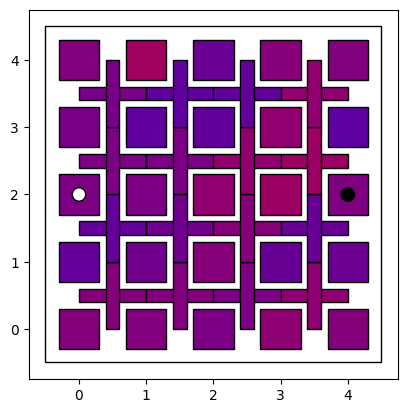

In [106]:
import matplotlib.pyplot as plt

quoridor = Quoridor(5, 1)
state = quoridor.get_initial_state()


model = QuoridorNet(quoridor, 3, 10)

tensor_input = torch.tensor(state.encode(0)).unsqueeze(0)
policy, value = model(tensor_input)

print(value)

plt.axis()
rect = plt.Rectangle((-0.5, -0.5), 5, 5, fc='w', ec='k')
plt.gca().add_patch(rect)

for i in range(5):
    for j in range(5):
        rate = float(policy[0, 0, i, j])
        color = np.array([1-rate, 0, rate, 1])
        rect = plt.Rectangle((i-0.3, j-0.3), 0.6, 0.6, fc=color, ec='k')
        plt.gca().add_patch(rect)

for i in range(4):
    for j in range(4):
        rate = float(policy[0, 0, i, j])
        color = np.array([1-rate, 0, rate, 1])
        rect = plt.Rectangle((i+0.5-0.5, j+0.5-0.1), 1, 0.2, fc=color, ec='k')
        plt.gca().add_patch(rect)

for i in range(4):
    for j in range(4):
        rate = float(policy[0, 0, i, j])
        color = np.array([1-rate, 0, rate, 1])
        rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.5), 0.2, 1, fc=color, ec='k')
        plt.gca().add_patch(rect)


circle = plt.Circle((state.positions[0, 0], state.positions[0, 1]), 0.1, fc='w',ec="k")
plt.gca().add_patch(circle)
circle = plt.Circle((state.positions[1, 0], state.positions[1, 1]), 0.1, fc='k',ec="k")
plt.gca().add_patch(circle)

plt.axis('scaled')
plt.show()